<table style="border:1px solid black;border-collapse:collapse;" align="left">
  <td style="border:1px solid red;">
    <a target="_blank" href="https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92">View Zhi Li's Gensim Word2Vec tutorial on `Towards Data Science`</a>
  </td>
  <td style="border:1px solid red;">
    <a target="_blank" href="https://colab.research.google.com/github/Grrtzm/word2vec/blob/main/windows_eventlog_anomaly_detection_with_gensim_word2vec.ipynb">Run this notebook in Google Colab</a>
  </td>
  <td style="border:1px solid red;">
    <a target="_blank" href="https://github.com/Grrtzm/word2vec/blob/main/windows_eventlog_anomaly_detection_with_gensim_word2vec.ipynb">View source on GitHub</a>
  </td>
  <td style="border:1px solid red;">
    <a href="https://github.com/zhlli1/Genism-word2vec/blob/master/Genism%20Word2Vec%20Tutorial.ipynb">Download original Word2Vec tutorial notebook</a>
  </td>
</table>

# Word2Vec on Windows Eventlogs
This notebook is part of a project that uses Word2Vec for anomaly detection in Windows 10 event logs.<br>
It uses a dataset which consists of all events derived from the System event log from my own PC.<br>
The data was read using Powershell and Get-WinEvent. You can find the Powershell script and the python script for parsing in my github repository.<br>
This version uses the Gensim implementation of Word2Vec, <a target="_blank" href="https://colab.research.google.com/github/Grrtzm/word2vec/blob/main/windows_eventlog_anomaly_detection_with_tensorflow_word2vec.ipynb">this version uses a Tensorflow implementation of Word2Vec</a>.

## Setup

In [1]:
!pip install gensim
import gensim

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import string
# from time import time  # To time our operations
from datetime import datetime # For DateTime -> date operations
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Word2Vec hyperparameters:
# num_ns: Set the number of negative samples per positive context.
# num_ns: between [5, 20] is shown to work best for smaller datasets, while num_ns between [2,5] suffices for larger datasets.
num_ns = 5
window_size = 5
embedding_dim = 20 #  20 seems to be sufficient, 128 is the default value from the tutorial   # Dimension of the dense embedding.
vocab_size = 20000 # inital size of the vocabulary. We will resize it later before defining the model.
# sequence_length = 40 # Number of words in a sentence.
epochs = 1000 # Number of training epochs for Word2Vec

# df = pd.read_csv('D:\logs\AllEvents-sorted.csv', parse_dates=["TimeCreated"]) 
df = pd.read_csv('D:/logs/winevt/20211202/System-Events-custom.csv', parse_dates=["TimeCreated"]) 
df.head()

,TimeCreated,EventRecordID,EventID,Level,Provider,Message
0,2021-12-02 20:05:22.768441+00:00,37593,System_1014,Warning,Microsoft-Windows-DNS-Client,Name resolution for the name config.teams.micr...
1,2021-12-02 20:05:22.255612+00:00,37592,System_32,Information,e1dexpress,NaN
2,2021-12-02 20:05:19.153883+00:00,37591,System_6062,Warning,Netwtw08,6062 - Lso was triggered
3,2021-12-02 20:05:18.362357+00:00,37590,System_27,Warning,e1dexpress,NaN
4,2021-12-02 20:05:18.278408+00:00,37589,System_32,Information,e1dexpress,NaN


## Create Event "word" from multiple columns
This creates a new column containing the words Word2Vec will be trained on.

In [3]:
import string
punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'   # `|` is not present here
transtab = str.maketrans(dict.fromkeys(punct, ''))

# Define a function to remove spaces
# Source: https://iqcode.com/code/python/pandas-series-remove-punctuation
# and https://stackoverflow.com/questions/50444346/fast-punctuation-removal-with-pandas
def remove_spaces(text):
    for punctuation in string.punctuation:
        text = text.replace(' ', '')
    return text

# Create a new column. Concatenate the columns, remove unwanted characters and convert to lowercase
df['Event'] = df['EventID'].map(str) + df['Level'].map(str) + df['Provider'].apply(remove_spaces).map(str)
df['Event'] = '|'.join(df['Event'].tolist()).translate(transtab).split('|') # remove all other unwanted characters
df['Event'] = df['Event'].str.lower()

# Delete the redundant columns
df = df.drop(['EventID','Level','Provider'], axis=1)

# Change order of columns by name, so we can display it orderly
df = df[['TimeCreated', 'EventRecordID', 'Event', 'Message']]

# Show a preview
df.head(8)

,TimeCreated,EventRecordID,Event,Message
0,2021-12-02 20:05:22.768441+00:00,37593,system1014warningmicrosoftwindowsdnsclient,Name resolution for the name config.teams.micr...
1,2021-12-02 20:05:22.255612+00:00,37592,system32informatione1dexpress,NaN
2,2021-12-02 20:05:19.153883+00:00,37591,system6062warningnetwtw08,6062 - Lso was triggered
3,2021-12-02 20:05:18.362357+00:00,37590,system27warninge1dexpress,NaN
4,2021-12-02 20:05:18.278408+00:00,37589,system32informatione1dexpress,NaN
5,2021-12-02 20:05:17.638712+00:00,37588,system1informationmicrosoftwindowspowertrouble...,The system has returned from a low power state...
6,2021-12-02 20:05:17.544184+00:00,37587,system7021informationnetwtw08,7021 - Connection telemetry fields and analysi...
7,2021-12-02 20:05:15.997321+00:00,37586,system18informationbthusb,Windows cannot store Bluetooth authentication ...


In [4]:
num_rows = len(df.axes[0])
print(f"Number of lines/events in the dataset: {num_rows}\n")

Number of lines/events in the dataset: 37593



# Data Preprocessing

Since the purpose of this tutorial is to learn how to generate word embeddings using genism library, I will not do the EDA and feature selection for the word2vec model for the sake of simplicity. 
<br> 
Gensim word2Vec requires that a format of list of list for training where every document is contained in a list and every list contains list of tokens of that document. At first, we need to generate a format of list of list for training the make model word embedding. To be more specific, each make model is contained in a list and every list contains list of features of that make model.
To achieve these, we need to do the following data preprocessing steps :
1. Create a new column for Make Model 
2. Generate a format of list of list for each Make Model with the following features: Engine Fuel Type, Transmission Type, Driven_Wheels, Market Category, Vehicle Size and Vehicle Style. 

In [5]:
# Hier creëer ik een tekst dataset eventlist, een list van lists. De list eventrow is gevuld met alle events van die dag.
# Zie ook blokje [8] van lees-data-v3
eventlist = []
eventrow = []
previous_date = None # datetime.now().date()
for idx, row in df.iterrows():
    date = row['TimeCreated'].date()
    eventrow.append(row['Event'])
    if date != previous_date:
        eventrow = []
        eventlist.append(eventrow)
        previous_date = date

In [6]:
# print(len(eventlist))
# print()
# print(eventlist[:3])

In [7]:
## Train the Gensim word2vec model with our own custom corpus

# Skip-gram:
model = Word2Vec(eventlist, min_count=1, vector_size=20, workers=8, window=3, sg=1, epochs=1000) #, compute_loss=True) #, callbacks=[epoch_logger])

# CBOW:
# model = Word2Vec(eventlist, min_count=1, vector_size=20, workers=8, window=3, sg=0, epochs=1000, hs=1, negative=0) #, compute_loss=True) #, callbacks=[epoch_logger])

word_vectors = model.wv
word_vectors.save('vectors.kv')
reloaded_word_vectors = KeyedVectors.load('vectors.kv')

Reference: https://radimrehurek.com/gensim/models/word2vec.html and https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4
Apparently, Gensim v4.0 was released on 31-3-2021

Let's try to understand the hyperparameter of this model.
1. vector_size: The number of dimensions of the embeddings and the default is 100.
2. window: The maximum distance between a target word and words around the target word. The default window is 5.
3. min_count: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.
4. workers: The number of partitions during training and the default workers is 3. 
5. sg: The training algorithm, either CBOW(0) or skip gram (1). The default training alogrithm is CBOW. 
6. epochs: number of training cycles
7. hs: 0, 1   1=hierarchical softmax

In [8]:
# https://radimrehurek.com/gensim/models/keyedvectors.html#module-gensim.models.keyedvectors
# distances(word_or_vector, other_words=())
# Compute cosine distances from given word or vector to all words in other_words. If other_words is empty, return distance between word_or_vectors and all words in vocab.

print(f"Number of words in internal Word2Vec vocabulary: {len(model.wv)}")
print(model.wv.get_vector('system137errorntfs', norm=True))
print()
print(model.wv.similarity('system136warningntfs','system137errorntfs'))
print()
print(model.wv.distance('system136warningntfs','system137errorntfs'))
print()
print(model.wv.distances('system137errorntfs', other_words=(["system26informationapplicationpopup","system51warningdisk"])))
print()
print(model.wv.distance('system137errorntfs','system26informationapplicationpopup'))
print()
print(model.wv.distance('system137errorntfs','system7040informationservicecontrolmanager'))
print()
print(model.wv.rank_by_centrality(['system51warningdisk','system137errorntfs'], use_norm=True))
print()

#print(model.wv['system18informationbthusb']) # Foutmelding: KeyError: "Key 'system18informationbthusb' not present"
# print(model.wv.most_similar('system136warningntfs')) # Foutmelding: KeyError: "Key 'system18informationbthusb' not present"
# print()
# print(model.wv.get_vector('system136warningntfs', norm=True))
# print()
# print(model.wv.evaluate_word_pairs('system136warningntfs','system137errorntfs')) # Dit werkt niet; FileNotFoundError: [Errno 2] No such file or directory: 'system136warningntfs'

Number of words in internal Word2Vec vocabulary: 191
[-0.09972199 -0.05199753  0.22557108  0.03612063  0.36131307  0.4322736
 -0.14152218 -0.1555398   0.08694224 -0.00394123  0.6227906  -0.08515584
 -0.14600158 -0.02637327  0.14227699  0.04556683  0.31561676  0.09180383
 -0.13054472 -0.03777501]

0.986393

0.013607025146484375

[0.53564554 0.32041925]

0.5356455445289612

0.7853798568248749

[(0.9164008, 'system51warningdisk'), (0.91640073, 'system137errorntfs')]



In [9]:
num_events = len(df.axes[0])
# add empty columns
cos_sim = []
for idx, row in df.iterrows():
    current_event = row['Event']
    if idx == 0:
        cos_sim.append(float(0))
        previous_event = current_event
    if idx > 0:
        if idx < num_events + 1:
            cs = model.wv.similarity(previous_event, current_event)
            cos_sim.append(cs)
            previous_event = current_event

df['cos_sim'] = cos_sim

# Change order of columns by name, so we can display it orderly
df = df[['TimeCreated', 'EventRecordID', 'Event', 'cos_sim', 'Message']]
df.head()

# saving the dataframe
df.to_csv('D:/logs/winevt/20211202/System-Events-dist.csv')

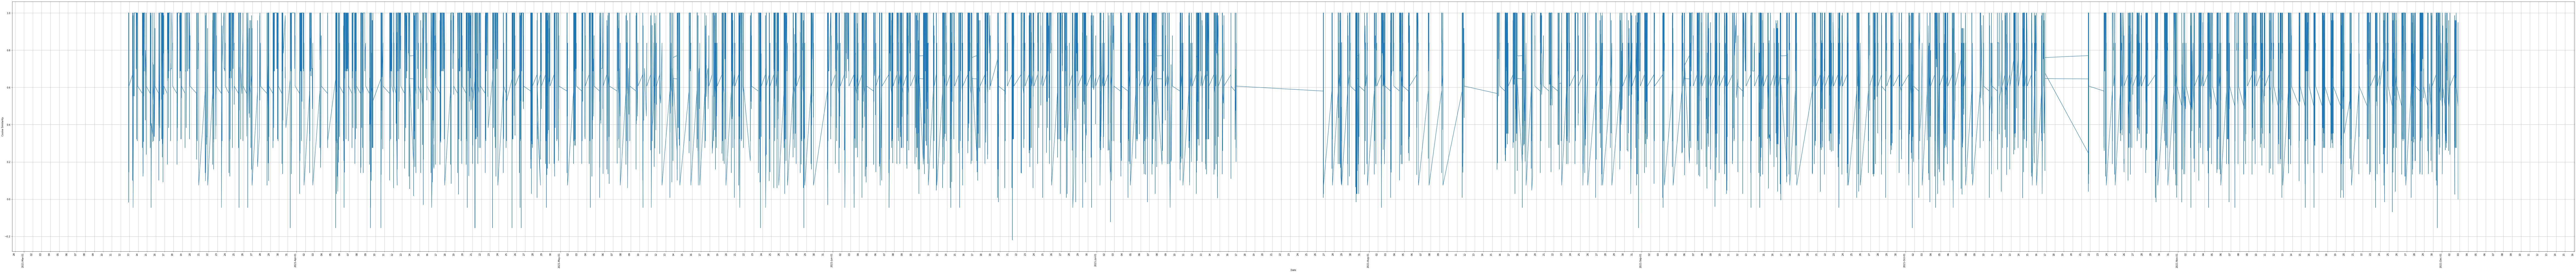

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(1, figsize=(200, 20))
x = df['TimeCreated']
y = df['cos_sim']
line, = ax.plot(x, y)
# Major ticks every month, minor ticks every day,
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.grid(True, which='both', axis='both')
# Text in the x axis will be displayed in 'YYYY-mm-dd' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b-%d'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=90, horizontalalignment='right')
for label in ax.get_xticklabels(which='minor'):
    label.set(rotation=90, horizontalalignment='right')
plt.xlabel("Date")
plt.ylabel("Cosine Similarity")
plt.savefig("cos_sim.png", format="png")
plt.show()

In [11]:
# Pandas display settings
# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.width',200)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.colheader_justify','left')
#df.style.set_properties(**{'text-align': 'left'})
#df.style.set_properties(subset=['Event', 'Message'], **{'text-align': 'left'})

#dfStyler = df.style.set_properties(**{'text-align': 'left'})
#dfStyler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
df.style.set_properties(**{'text-align': 'left'}).set_table_styles([ dict(selector='th', props=[('text-align', 'left')] ) ])

print("Top 10 of all 'anomalies':\n")
df.nsmallest(n=10, columns=['cos_sim'])

Top 10 of all 'anomalies':



,TimeCreated,EventRecordID,Event,cos_sim,Message
23032,2021-06-21 10:00:00.457651+00:00,14561,system6013informationeventlog,-0.219155,The system uptime is 136964 seconds.
579,2021-11-30 11:19:19.259901+00:00,37014,system6013informationeventlog,-0.154296,The system uptime is 18 seconds.
9450,2021-10-01 18:28:27.644559+00:00,28143,system6013informationeventlog,-0.154296,The system uptime is 14 seconds.
14511,2021-08-31 15:15:33.897800+00:00,23082,system6013informationeventlog,-0.154296,The system uptime is 26 seconds.
26735,2021-05-28 16:47:03.808171+00:00,10858,system6013informationeventlog,-0.154296,The system uptime is 18 seconds.
27951,2021-05-23 18:35:09.301496+00:00,9642,system6013informationeventlog,-0.154296,The system uptime is 25 seconds.
30934,2021-04-26 13:11:55.734366+00:00,6659,system6013informationeventlog,-0.154296,The system uptime is 19 seconds.
31149,2021-04-25 12:12:18.104993+00:00,6444,system6013informationeventlog,-0.154296,The system uptime is 27 seconds.
31410,2021-04-23 06:54:16.663283+00:00,6183,system6013informationeventlog,-0.154296,The system uptime is 21 seconds.
31683,2021-04-21 07:03:08.631865+00:00,5910,system6013informationeventlog,-0.154296,The system uptime is 19 seconds.


In [12]:
# Save result to a file:
# df.to_csv('D:/Machine_Learning/word2vec/file1.csv')

In [19]:
# Only display the rows containing 'critical'
dfcritical = df[df['Event'].str.contains('critical')]
print(f"Top 10 of 'critical' anomalies from a total of {len(dfcritical)} 'critical' events:\n")
dfcritical.nsmallest(n=10, columns=['cos_sim'])

Top 10 of 'critical' anomalies from a total of 14 'critical' events:



,TimeCreated,EventRecordID,Event,cos_sim,Message
570,2021-11-30 11:19:04.976339+00:00,37023,system41criticalmicrosoftwindowskernelpower,0.724455,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
9440,2021-10-01 18:28:17.428702+00:00,28153,system41criticalmicrosoftwindowskernelpower,0.724455,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
14500,2021-08-31 15:15:12.123075+00:00,23093,system41criticalmicrosoftwindowskernelpower,0.724455,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
26725,2021-05-28 16:46:49.554694+00:00,10868,system41criticalmicrosoftwindowskernelpower,0.724455,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
27941,2021-05-23 18:34:47.785323+00:00,9652,system41criticalmicrosoftwindowskernelpower,0.724455,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
30925,2021-04-26 13:11:40.205236+00:00,6668,system41criticalmicrosoftwindowskernelpower,0.724455,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
31140,2021-04-25 12:11:55.396258+00:00,6453,system41criticalmicrosoftwindowskernelpower,0.724455,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
31401,2021-04-23 06:53:59.632369+00:00,6192,system41criticalmicrosoftwindowskernelpower,0.724455,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
31674,2021-04-21 07:02:53.221205+00:00,5919,system41criticalmicrosoftwindowskernelpower,0.724455,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
31759,2021-04-21 07:00:39.765228+00:00,5834,system41criticalmicrosoftwindowskernelpower,0.724455,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."


In [18]:
# Only display the rows containing 'error'
dferror = df[df['Event'].str.contains('error')]
print(f"Top 10 of 'error' anomalies from a total of {len(dferror)} 'error' events:\n")
dferror.nsmallest(n=10, columns=['cos_sim'])

Top 10 of 'error' anomalies from a total of 1054 'error' events:



,TimeCreated,EventRecordID,Event,cos_sim,Message
11792,2021-09-15 09:59:49.923530+00:00,25801,system12errorvboxnetlwf,0.058487,The driver detected an internal driver error on \Device\VBoxNetLwf.
8009,2021-10-12 11:58:39.981726+00:00,29584,system12errorvboxnetlwf,0.131266,The driver detected an internal driver error on \Device\VBoxNetLwf.
30501,2021-04-29 11:16:26.823498+00:00,7092,system12errorvboxnetlwf,0.131266,The driver detected an internal driver error on \Device\VBoxNetLwf.
4409,2021-11-10 12:48:17.761535+00:00,33184,system7034errorservicecontrolmanager,0.181476,The OfficeSvcManagerAddons service terminated unexpectedly. It has done this 1 time(s).
29477,2021-05-09 14:49:37.884761+00:00,8116,system10010errormicrosoftwindowsdistributedcom,0.186499,The server Microsoft.SkypeApp_15.68.96.0_x86__kzf8qxf38zg5c!App.AppXtwmqn4em5r5dpafgj4t4yyxgjfe0hr50.mca did not register with DCOM within the required timeout.
32096,2021-04-18 12:13:42.183632+00:00,5497,system10010errormicrosoftwindowsdistributedcom,0.186499,The server Microsoft.SkypeApp_15.68.96.0_x86__kzf8qxf38zg5c!App.AppXtwmqn4em5r5dpafgj4t4yyxgjfe0hr50.mca did not register with DCOM within the required timeout.
32221,2021-04-17 07:38:17.117611+00:00,5372,system10010errormicrosoftwindowsdistributedcom,0.186499,The server Microsoft.SkypeApp_15.68.96.0_x86__kzf8qxf38zg5c!App.AppXtwmqn4em5r5dpafgj4t4yyxgjfe0hr50.mca did not register with DCOM within the required timeout.
32239,2021-04-16 19:21:22.771181+00:00,5354,system10010errormicrosoftwindowsdistributedcom,0.186499,The server Microsoft.SkypeApp_15.68.96.0_x86__kzf8qxf38zg5c!App.AppXtwmqn4em5r5dpafgj4t4yyxgjfe0hr50.mca did not register with DCOM within the required timeout.
33633,2021-04-09 06:54:45.396437+00:00,3960,system10010errormicrosoftwindowsdistributedcom,0.186499,The server Microsoft.SkypeApp_15.68.96.0_x86__kzf8qxf38zg5c!App.AppXtwmqn4em5r5dpafgj4t4yyxgjfe0hr50.mca did not register with DCOM within the required timeout.
35621,2021-03-27 13:29:05.829182+00:00,1972,system10010errormicrosoftwindowsdistributedcom,0.186499,The server Microsoft.SkypeApp_15.68.96.0_x86__kzf8qxf38zg5c!App.AppXtwmqn4em5r5dpafgj4t4yyxgjfe0hr50.mca did not register with DCOM within the required timeout.
